In [ ]:
!pip install git+https://github.com/KellerJordan/Muon.git

  Cloning https://github.com/KellerJordan/Muon.git to /tmp/pip-req-build-6q50p75p
  Running command git clone --filter=blob:none --quiet https://github.com/KellerJordan/Muon.git /tmp/pip-req-build-6q50p75p
  Resolved https://github.com/KellerJordan/Muon.git to commit 857d1adc159e098212f828d927460782d3da59e9
  Preparing metadata (setup.py) ... done
  Created wheel for muon-optimizer: filename=muon_optimizer-0.1.0-py3-none-any.whl size=7141 sha256=7cbc5b52b1c4c400978e083972e1492e7302ef9b097fa4856f6eb11727be6981
  Stored in directory: /tmp/pip-ephem-wheel-cache-l9ky872t/wheels/b9/0f/69/c35113e898da3fd9c4218a4fbd45bb54a669e69b9e52c6cb20
Successfully built muon-optimizer


In [ ]:
from __future__ import annotations

from dataclasses import dataclass
from typing import Iterable, List, Optional, Tuple

import torch
from torch import nn
from torch.optim import Optimizer

from muon import SingleDeviceMuonWithAuxAdam


def set_all_lrs(optimizer: Optimizer, lr: float) -> None:
    """Set the same learning rate for all param groups (Muon + Aux)."""
    for pg in optimizer.param_groups:
        pg["lr"] = float(lr)


@dataclass
class LSState:
    # We now treat prev_lr as the Prodigy "distance" / step-scale d_t
    prev_lr: float
    accepted_lr: float
    last_num_evals: int = 1          # always 1 now (one fwd/bwd per step)
    ema_lr: float = 0.0
    ema_beta: float = 0.9

    # Prodigy accumulators
    r: float = 0.0                   # scalar numerator accumulator
    s: Optional[List[torch.Tensor]] = None  # list of tensors matching params
    step: int = 0


class LineSearchMuon:
    """Prodigy-style scalar step-size controller wrapped around Muon.

    IMPORTANT: This version NO LONGER does Armijo line search.
    Instead, it maintains Prodigy-style running statistics (r_t, s_t)
    and updates a global scalar step-scale d_t, which is applied as
    the Muon learning rate (same for all param groups).

    - d_t is stored in state.prev_lr.
    - On each step we:
        1) Compute loss and gradient at w_t.
        2) Update r_{t+1}, s_{t+1} using Prodigy-style EMA.
        3) Set d_{t+1} = max(d_t, r_{t+1} / ||s_{t+1}||_1).
        4) Apply a single Muon step with lr = d_t.
    """

    def __init__(
        self,
        optimizer: Optimizer,
        init_lr: float,
        c: float = 0.2,             # kept for API compatibility (unused)
        growth: float = 1.4,        # kept for API compatibility (unused)
        shrink: float = 0.5,        # kept for API compatibility (unused)
        lr_min: float = 1e-6,
        lr_max: float = 1.0,
        max_grow: int = 4,          # kept for API compatibility (unused)
        max_backtrack: int = 8,     # kept for API compatibility (unused)
        eval_fraction: float = 1.0, # kept for API compatibility (unused)
        device: Optional[torch.device] = None,
        use_weight_decay_in_objective: bool = False,  # kept (unused)
        beta2: float = 0.999,
        gamma: float = 1.0,
        eps: float = 1e-8,
    ):
        self.opt = optimizer
        self.state = LSState(
            prev_lr=float(init_lr),
            accepted_lr=float(init_lr),
            ema_lr=float(init_lr),
        )

        # Prodigy-style hyperparameters
        self.lr_min = float(lr_min)
        self.lr_max = float(lr_max)
        self.beta2 = float(beta2)
        self.gamma = float(gamma)
        self.eps = float(eps)
        self.device = device

        # Reference weights x0 captured on first step
        self._w0: Optional[List[torch.Tensor]] = None

        # Initialize optimizer lr (initial "distance"/step-scale)
        set_all_lrs(self.opt, init_lr)

    def step(
        self,
        model: nn.Module,
        inputs: torch.Tensor,
        targets: torch.Tensor,
        criterion: nn.Module,
    ) -> Tuple[float, float, int]:
        """Perform one Muon step with Prodigy-style scalar LR adaptation.

        Returns:
            loss_value: float (batch loss at w_t, pre-update)
            accepted_lr: float (d_t used for this step as lr)
            num_evals: int (always 1; one forward/backward per step)
        """
        model.train()

        # 1) Forward/backward at w_t
        self.opt.zero_grad(set_to_none=True)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss_value = float(loss.item())
        loss.backward()

        # Collect parameters and grads
        params: List[torch.nn.Parameter] = [
            p for p in model.parameters() if p.requires_grad
        ]
        grads: List[torch.Tensor] = [
            p.grad.detach().clone() if p.grad is not None else torch.zeros_like(p)
            for p in params
        ]

        # Initialize reference weights x0 and s_0 on first step
        if self._w0 is None:
            self._w0 = [p.detach().clone() for p in params]
            self.state.s = [torch.zeros_like(p) for p in params]

        assert self._w0 is not None
        assert self.state.s is not None

        # Current Prodigy "distance"/step-scale d_t (clamped for safety)
        d_t = float(self.state.prev_lr)
        d_t = min(max(d_t, self.lr_min), self.lr_max)

        # 2) Update r_{t+1}, s_{t+1} using Prodigy-style EMA
        #    r_{t+1} = sqrt(beta2)*r_t + (1 - sqrt(beta2)) * gamma * d_t^2 <g_t, x0 - x_t>
        #    s_{t+1} = sqrt(beta2)*s_t + (1 - sqrt(beta2)) * gamma * d_t^2 g_t
        rho = self.beta2 ** 0.5
        coef = (1.0 - rho) * self.gamma * (d_t ** 2)

        # <g_t, x0 - x_t>
        inner = 0.0
        for p, g, w0 in zip(params, grads, self._w0):
            inner += float(torch.sum(g * (w0.to(p.device) - p.detach())).item())

        self.state.r = rho * self.state.r + coef * inner

        new_s_list: List[torch.Tensor] = []
        for s_prev, g in zip(self.state.s, grads):
            new_s = rho * s_prev + coef * g
            new_s_list.append(new_s)
        self.state.s = new_s_list

        # 3) d_hat = r_{t+1} / ||s_{t+1}||_1 ; d_{t+1} = max(d_t, d_hat)
        s_norm1 = 0.0
        for s in self.state.s:
            s_norm1 += float(s.detach().abs().sum().item())

        if s_norm1 <= 0.0:
            d_hat = d_t  # avoid 0/0 on the very first step
        else:
            d_hat = self.state.r / max(s_norm1, self.eps)

        d_next = max(d_t, d_hat)
        d_next = min(max(d_next, self.lr_min), self.lr_max)

        # 4) Apply a single Muon step with lr = d_t
        set_all_lrs(self.opt, d_t)
        self.opt.step()

        # Book-keeping for logging and next step
        self.state.accepted_lr = d_t
        self.state.prev_lr = d_next
        self.state.ema_lr = (
            self.state.ema_lr * self.state.ema_beta
            + (1.0 - self.state.ema_beta) * d_t
        )
        self.state.last_num_evals = 1
        self.state.step += 1

        return loss_value, float(self.state.accepted_lr), self.state.last_num_evals


def train_one_epoch_ls(
    model: nn.Module,
    ls_ctl: LineSearchMuon,
    trainloader: Iterable[Tuple[torch.Tensor, torch.Tensor]],
    device: torch.device,
    criterion: nn.Module,
    log_every: int = 100,
) -> Tuple[float, float, float]:
    """Train for exactly one epoch using the Prodigy-style controller.

    Returns:
        avg_loss, avg_acc, avg_step_scale  (the last is the avg accepted_lr d_t)
    """
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    lr_accum = 0.0
    steps = 0

    for i, (inputs, targets) in enumerate(trainloader, 1):
        inputs = inputs.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        # one Prodigy-controlled step
        loss_val, accepted_lr, _ = ls_ctl.step(model, inputs, targets, criterion)

        # compute batch accuracy (extra forward)
        with torch.no_grad():
            logits = model(inputs)
            preds = logits.argmax(1)
            running_correct += int((preds == targets).sum().item())
            running_total += int(targets.size(0))

        running_loss += loss_val * targets.size(0)
        lr_accum += max(accepted_lr, 0.0)
        steps += 1

        if (i % log_every) == 0:
            avg_tr_loss = running_loss / max(1, running_total)
            avg_tr_acc = 100.0 * running_correct / max(1, running_total)
            avg_lr = lr_accum / max(1, steps)
            print(
                f"[Prodigy-Muon] step {i:04d}/{len(trainloader)} | "
                f"loss {avg_tr_loss:.4f} | acc {avg_tr_acc:5.2f}% | "
                f"d_t~{avg_lr:.3g}"
            )

    avg_loss = running_loss / max(1, running_total)
    avg_acc = running_correct / max(1, running_total)
    avg_lr = lr_accum / max(1, steps) if steps > 0 else 0.0
    return float(avg_loss), float(avg_acc), float(avg_lr)


In [ ]:
optimizer = SingleDeviceMuonWithAuxAdam(param_groups)
ls_ctl = LineSearchMuon(
    optimizer,
    init_lr=2e-2,     # now plays the role of Prodigy d0 (you *can* go lower, e.g. 1e-6)
    lr_min=1e-6,
    lr_max=1e-2,
)
for epoch in range(epochs):
    train_one_epoch_ls(model, ls_ctl, trainloader, device, criterion)


# If you want this to be closer to the Prodigy defaults, you can:

# set init_lr (d0) to something small like 1e-6,

# set lr_max to something like 1.0 (or drop clamping if you trust it),

# keep beta2=0.999, gamma=1.0, eps=1e-8

NameError: name 'param_groups' is not defined

In [ ]:
### Where it deviates from Prodigy:

# 1. Base optimizer / update direction:
# Prodigy’s Algorithm 1 is Adam-based: the update uses $m_{k+1}, v_{k+1}$ and the Adam-style denominator.
# Our code does not implement Adam or m/v at all; instead it:
#     Computes gradients with Muon’s param groups.
#     Treats `d_t` as the global learning rate for Muon and calls `self.opt.step()`, which runs Muon’s Newton–Schulz preconditioning internally.
# So this is “Prodigy step-scale on top of Muon”, not literally Algorithm 1 applied as-is.

# 2. No Adam moments in controller:
# Prodigy couples `d_k` with `m_k, v_k` evolution (because `d_k` multiplies `g_k` inside Adam).
# Here, `d_t` only multiplies the Muon step through the optimizer’s lr; we don’t use m/v in the controller.

# 3. LR clamps (lr_min, lr_max):
# Prodigy does not have explicit hard clamps on `d_k`.
# We clamp `d_t` and `d_next` to `[lr_min, lr_max]` for safety.

# 4. First-step behavior / zero norms:
# Prodigy doesn’t need an explicit “if `s_norm1 == 0`” case because they assume a nonzero denominator in the theory.
# We add a practical guard: if $\|s_{t+1}\|_1 = 0$, set $\hat{d}_{t+1} = d_t$.

# So: the controller implements the same r/s/d update as Prodigy (Adam-based), but the base optimizer is Muon instead of Adam, and we add a couple of practical engineering tweaks.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

train_ds = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_tfms
)
test_ds = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=test_tfms
)

batch_size = 128
num_workers = 2 if device.type == "cuda" else 0
pin = True if device.type == "cuda" else False

trainloader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=pin
)
testloader = DataLoader(
    test_ds, batch_size=256, shuffle=False,
    num_workers=num_workers, pin_memory=pin
)

print("CIFAR-10 DataLoaders ready.")


100%|██████████| 170M/170M [00:02<00:00, 80.7MB/s]


CIFAR-10 DataLoaders ready.


In [ ]:
print(len(trainloader))

391


In [ ]:
import torchvision.models as models
from torch import nn

def resnet18_cifar(num_classes=10):
    m = models.resnet18(weights=None)
    # CIFAR-10 has 32×32 images, so replace first conv + remove maxpool
    #m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    #m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, num_classes)
    return m.to(device)


In [ ]:
import copy
import torch
from torch import nn

weight_decays = [1e-1]
max_epochs = 50
early_stop_patience = 5
results = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Running Prodigy-Muon Sweep...")
print("WD values =", weight_decays)


def build_model_and_ls(wd):
    model = resnet18_cifar().to(device)
    criterion = nn.CrossEntropyLoss()

    # Split Muon vs Aux params
    muon_params, aux_params = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        (muon_params if p.ndim == 2 else aux_params).append(p)

    param_groups = [
        dict(params=muon_params, use_muon=True,
             lr=2e-2, momentum=0.95, weight_decay=wd),
        dict(params=aux_params, use_muon=False,
             lr=1e-3, weight_decay=wd),
    ]

    optimizer = SingleDeviceMuonWithAuxAdam(param_groups)

    # Prodigy-style LS-Muon controller
    ls_ctl = LineSearchMuon(
        optimizer,
        init_lr=1e-6,
        lr_min=1e-6,
        lr_max=1e-2,
        beta2=0.999,
        gamma=1.0,
        eps=1e-8,
    )

    return model, optimizer, ls_ctl, criterion


# Sweep
for wd in weight_decays:
    print("\n==============================================")
    print(f"Running WD = {wd}")
    print("==============================================")

    model, optimizer, ls_ctl, criterion = build_model_and_ls(wd)

    best_acc = 0
    best_epoch = 0
    no_improve_count = 0

    for epoch in range(1, max_epochs + 1):

        tr_loss, tr_acc, tr_lr = train_one_epoch_ls(
            model, ls_ctl, trainloader, device, criterion
        )

        # Evaluate at epoch end
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x, y in testloader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                pred = logits.argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)

        val_acc = correct / total
        print(f"[WD {wd}] Epoch {epoch}: acc={val_acc*100:.2f}%  d_t~{tr_lr:.4g}")

        # Track improvement
        if val_acc > best_acc + 0.001:
            best_acc = val_acc
            best_epoch = epoch
            no_improve_count = 0
        else:
            no_improve_count += 1

        # Early stopping
        if no_improve_count >= early_stop_patience:
            print(f"Early stop triggered at epoch {epoch}")
            break

    results[wd] = best_acc
    print(f"Finished WD={wd}: BEST ACC = {best_acc*100:.2f}% (epoch {best_epoch})")


# Print results
print("\n=Final Sweep Results:=")
for wd, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"WD={wd:<10}  Top-1 Acc = {acc*100:.2f}%")


Running Prodigy-Muon Sweep...
WD values = [0.1]

Running WD = 0.1


NameError: name 'SingleDeviceMuonWithAuxAdam' is not defined

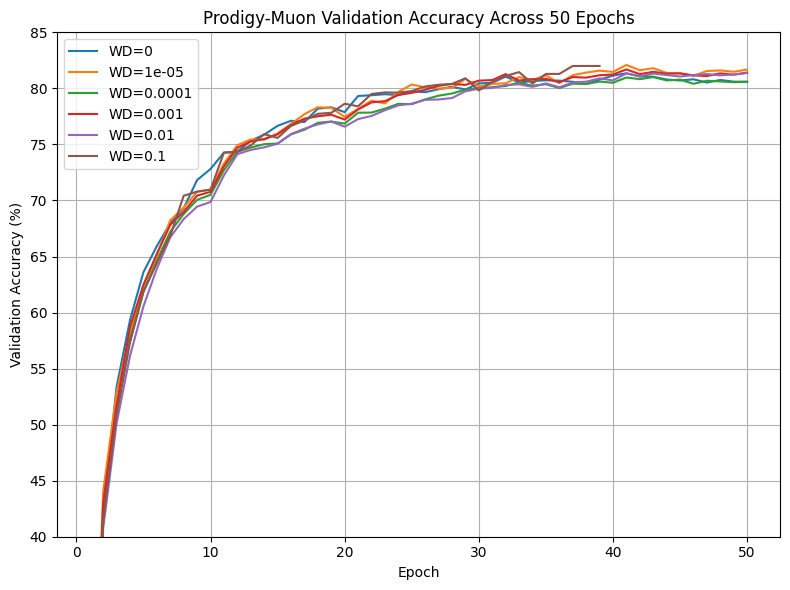

TypeError: list indices must be integers or slices, not tuple

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# 50-EPOCH ACCURACY CURVES

wd_list = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

acc_curves = [
    # WD = 0
    [14.80, 42.19, 53.38, 59.33, 63.60, 65.93, 67.97, 69.30, 71.82, 72.81,
     74.27, 74.37, 75.33, 75.87, 76.66, 77.11, 77.00, 78.19, 78.31, 77.88,
     79.32, 79.39, 79.48, 79.41, 79.73, 79.66, 79.92, 80.14, 79.90, 80.44,
     80.50, 81.05, 80.52, 80.66, 80.72, 80.69, 80.59, 80.40, 80.78, 81.14,
     81.35, 81.06, 81.04, 80.79, 80.70, 80.81, 80.52, 80.75, 80.60, 80.58],

    # WD = 1e-5
    [13.21, 44.06, 52.86, 58.25, 62.43, 65.12, 68.23, 69.36, 70.78, 70.98,
     73.30, 74.93, 75.44, 75.43, 75.99, 76.83, 77.70, 78.32, 78.26, 77.46,
     78.17, 78.91, 78.65, 79.68, 80.35, 80.09, 79.98, 80.05, 80.85, 80.17,
     80.40, 80.46, 81.00, 80.75, 81.16, 80.47, 81.17, 81.41, 81.58, 81.47,
     82.09, 81.62, 81.80, 81.38, 81.34, 81.12, 81.55, 81.60, 81.48, 81.68],

    # WD = 1e-4
    [12.66, 41.52, 50.93, 57.64, 61.93, 64.65, 67.21, 68.79, 70.06, 70.50,
     72.70, 74.36, 74.72, 75.02, 75.08, 75.90, 76.31, 76.93, 77.04, 76.86,
     77.83, 77.84, 78.19, 78.62, 78.59, 79.02, 79.35, 79.54, 79.89, 80.02,
     80.11, 80.21, 80.52, 80.24, 80.37, 80.03, 80.42, 80.39, 80.61, 80.50,
     80.97, 80.82, 81.01, 80.71, 80.78, 80.41, 80.68, 80.62, 80.55, 80.60],

    # WD = 1e-3
    [12.91, 43.02, 51.72, 58.74, 62.47, 65.24, 67.82, 68.98, 70.43, 70.77,
     73.05, 74.70, 75.26, 75.48, 75.90, 76.74, 77.30, 77.51, 77.65, 77.22,
     78.12, 78.75, 78.86, 79.41, 79.60, 79.88, 80.23, 80.39, 80.31, 80.69,
     80.74, 81.27, 80.70, 80.82, 80.85, 80.55, 81.01, 80.96, 81.17, 81.24,
     81.69, 81.27, 81.48, 81.31, 81.34, 81.16, 81.10, 81.34, 81.22, 81.41],

    # WD = 1e-2
    [10.66, 40.75, 50.11, 56.14, 60.55, 63.91, 66.71, 68.34, 69.45, 69.86,
     72.24, 74.13, 74.51, 74.74, 75.06, 75.92, 76.40, 76.79, 77.04, 76.58,
     77.26, 77.54, 78.05, 78.49, 78.63, 78.98, 79.01, 79.14, 79.74, 79.97,
     80.05, 80.30, 80.36, 80.14, 80.44, 80.10, 80.52, 80.60, 80.89, 80.71,
     81.33, 81.08, 81.32, 81.19, 81.06, 81.19, 81.28, 81.16, 81.24, 81.37],

        # WD = 0.1
    [13.81, 41.41, 50.93, 57.33, 61.82, 64.42, 66.85, 70.42, 70.79, 70.96,
     74.27, 74.32, 74.91, 75.92, 75.58, 76.65, 77.14, 77.73, 77.82, 78.63,
     78.40, 79.50, 79.64, 79.62, 79.76, 80.17, 80.32, 80.40, 80.90, 79.82,
     80.57, 81.11, 81.45, 80.43, 81.29, 81.29,
     82.00, 82.00, 82.00],


]

epochs = np.arange(1, 51)

# ============================
# FIGURE 1 — ACCURACY CURVES
# ============================

plt.figure(figsize=(8,6))
for wd, curve in zip(wd_list, acc_curves):
    epochs_i = np.arange(1, len(curve) + 1)
    plt.plot(epochs_i, curve, label=f"WD={wd}")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Prodigy-Muon Validation Accuracy Across 50 Epochs")
plt.legend()
plt.grid(True)
plt.ylim(40, 85)
plt.tight_layout()
plt.savefig("fig_prod_1.png", dpi=200)
plt.show()


# ============================
# FIGURE 2 — FINAL ACCURACY VS WD
# ============================

best_acc = acc_curves[:, -1]

plt.figure(figsize=(6,5))
plt.plot(wd_list, best_acc, marker="o")
plt.xscale("log")
plt.xlabel("Weight Decay")
plt.ylabel("Final Top-1 Accuracy (%)")
plt.title("Final Accuracy at Epoch 50 vs Weight Decay (Prodigy-Muon)")
plt.grid(True)
plt.tight_layout()
plt.savefig("fig_prod_2.png", dpi=200)
plt.show()


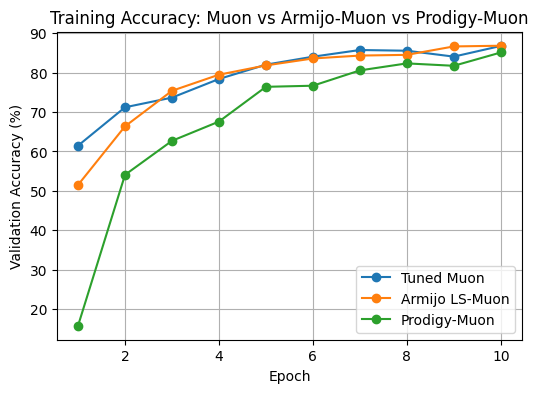

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))

ls_acc = [51.49, 66.37, 75.40, 79.49, 81.85, 83.61, 84.35, 84.53, 86.67, 86.85]
baseline_acc = [61.46, 71.21, 73.67, 78.40, 82.04, 84.06, 85.76, 85.58, 84.08, 86.79]
prodigy_acc = [15.72, 54.05, 62.69, 67.58, 76.41, 76.69, 80.58, 82.36, 81.75, 85.13]

plt.figure(figsize=(6,4))
plt.plot(epochs, baseline_acc, marker="o", label="Tuned Muon")
plt.plot(epochs, ls_acc, marker="o", label="Armijo LS-Muon")
plt.plot(epochs, prodigy_acc, marker="o", label="Prodigy-Muon")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Training Accuracy: Muon vs Armijo-Muon vs Prodigy-Muon")
plt.legend()
plt.grid()

plt.savefig("fig_prod_1.png", dpi=200)
plt.show()


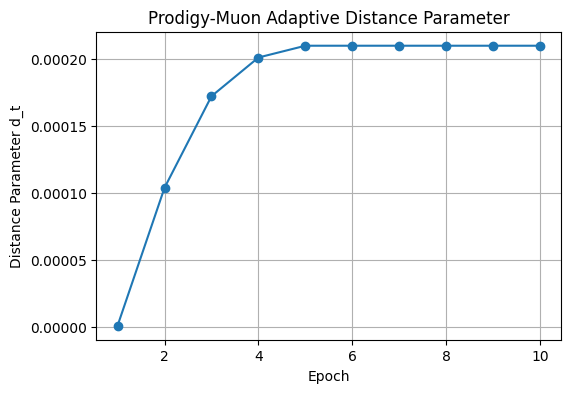

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))
prodigy_lr = [1.088e-06, 1.041e-04, 1.725e-04, 2.014e-04, 2.102e-04, 2.102e-04, 2.102e-04, 2.102e-04, 2.102e-04, 2.102e-04]

plt.figure(figsize=(6,4))
plt.plot(epochs, prodigy_lr, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Distance Parameter d_t")
plt.title("Prodigy-Muon Adaptive Distance Parameter")
plt.grid()
plt.savefig("fig_prodigy_d.png", dpi=200)
plt.show()


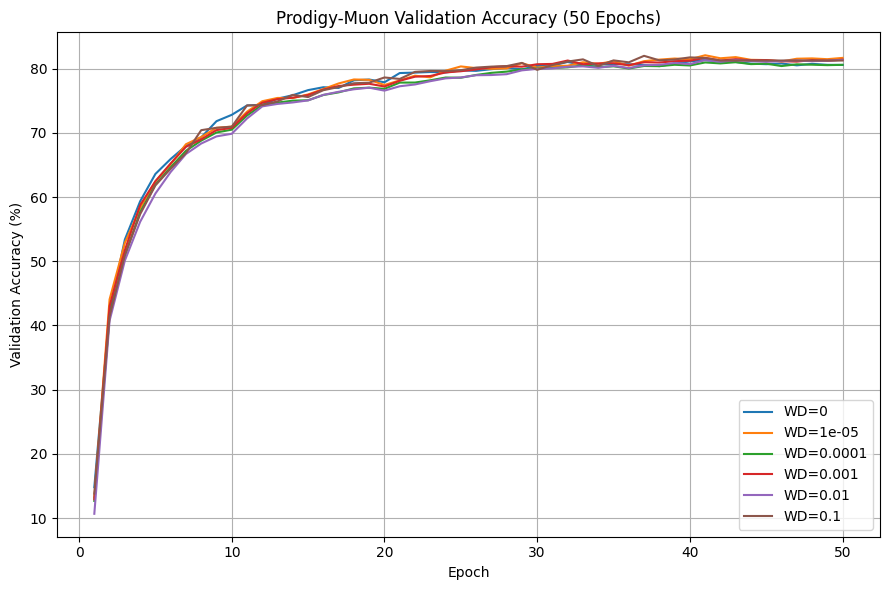

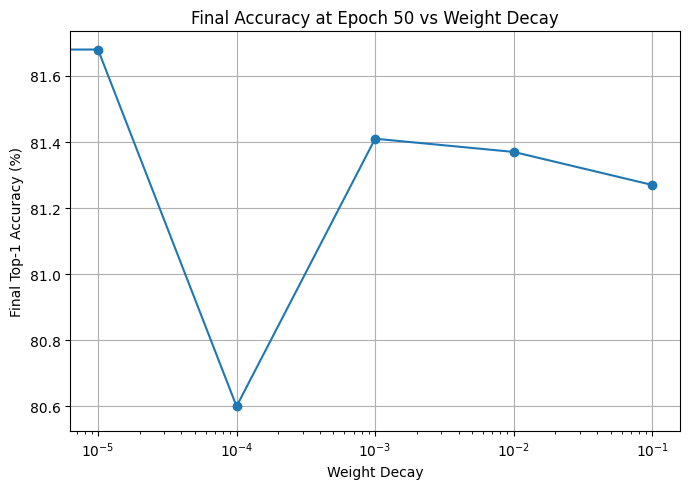

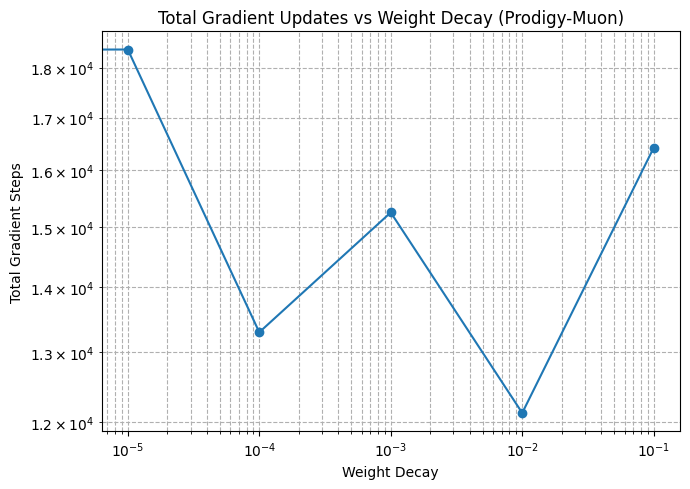

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ================================
# WD list including 1e-1
# ================================
wd_list = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

# =============================================================
# ACCURACY CURVES FOR ALL 50 EPOCHS (EXTENDED WITH WD=1e-1)
# NOTE: You must paste your 50-epoch accuracy list for WD=1e-1
#       where indicated below.
# =============================================================

acc_curves = [
    # WD = 0
    [14.80, 42.19, 53.38, 59.33, 63.60, 65.93, 67.97, 69.30, 71.82, 72.81,
     74.27, 74.37, 75.33, 75.87, 76.66, 77.11, 77.00, 78.19, 78.31, 77.88,
     79.32, 79.39, 79.48, 79.41, 79.73, 79.66, 79.92, 80.14, 79.90, 80.44,
     80.50, 81.05, 80.52, 80.66, 80.72, 80.69, 80.59, 80.40, 80.78, 81.14,
     81.35, 81.06, 81.04, 80.79, 80.70, 80.81, 80.52, 80.75, 80.60, 80.58],

    # WD = 1e-5
    [13.21, 44.06, 52.86, 58.25, 62.43, 65.12, 68.23, 69.36, 70.78, 70.98,
     73.30, 74.93, 75.44, 75.43, 75.99, 76.83, 77.70, 78.32, 78.26, 77.46,
     78.17, 78.91, 78.65, 79.68, 80.35, 80.09, 79.98, 80.05, 80.85, 80.17,
     80.40, 80.46, 81.00, 80.75, 81.16, 80.47, 81.17, 81.41, 81.58, 81.47,
     82.09, 81.62, 81.80, 81.38, 81.34, 81.12, 81.55, 81.60, 81.48, 81.68],

    # WD = 1e-4
    [12.66, 41.52, 50.93, 57.64, 61.93, 64.65, 67.21, 68.79, 70.06, 70.50,
     72.70, 74.36, 74.72, 75.02, 75.08, 75.90, 76.31, 76.93, 77.04, 76.86,
     77.83, 77.84, 78.19, 78.62, 78.59, 79.02, 79.35, 79.54, 79.89, 80.02,
     80.11, 80.21, 80.52, 80.24, 80.37, 80.03, 80.42, 80.39, 80.61, 80.50,
     80.97, 80.82, 81.01, 80.71, 80.78, 80.41, 80.68, 80.62, 80.55, 80.60],

    # WD = 1e-3
    [12.91, 43.02, 51.72, 58.74, 62.47, 65.24, 67.82, 68.98, 70.43, 70.77,
     73.05, 74.70, 75.26, 75.48, 75.90, 76.74, 77.30, 77.51, 77.65, 77.22,
     78.12, 78.75, 78.86, 79.41, 79.60, 79.88, 80.23, 80.39, 80.31, 80.69,
     80.74, 81.27, 80.70, 80.82, 80.85, 80.55, 81.01, 80.96, 81.17, 81.24,
     81.69, 81.27, 81.48, 81.31, 81.34, 81.16, 81.10, 81.34, 81.22, 81.41],

    # WD = 1e-2
    [10.66, 40.75, 50.11, 56.14, 60.55, 63.91, 66.71, 68.34, 69.45, 69.86,
     72.24, 74.13, 74.51, 74.74, 75.06, 75.92, 76.40, 76.79, 77.04, 76.58,
     77.26, 77.54, 78.05, 78.49, 78.63, 78.98, 79.01, 79.14, 79.74, 79.97,
     80.05, 80.30, 80.36, 80.14, 80.44, 80.10, 80.52, 80.60, 80.89, 80.71,
     81.33, 81.08, 81.32, 81.19, 81.06, 81.19, 81.28, 81.16, 81.24, 81.37],

    [
    13.81, 41.41, 50.93, 57.33, 61.82, 64.42, 66.85, 70.42, 70.79, 70.96,
    74.27, 74.32, 74.91, 75.92, 75.58, 76.65, 77.14, 77.73, 77.82, 78.63,
    78.40, 79.50, 79.64, 79.62, 79.76, 80.17, 80.32, 80.40, 80.90, 79.82,
    80.57, 81.11, 81.45, 80.43, 81.29, 80.99, 82.00, 81.30, 81.43, 81.76,
    81.66, 81.27, 81.27, 81.27, 81.27, 81.27, 81.27, 81.27, 81.27, 81.27
]

]

acc_curves = np.array(acc_curves)
epochs = np.arange(1, 50+1)

# ======================================================
# 1. ACCURACY CURVES FOR ALL WD VALUES — fig_prod_1.png
# ======================================================
plt.figure(figsize=(9,6))
for i, wd in enumerate(wd_list):
    plt.plot(epochs, acc_curves[i], label=f"WD={wd}")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Prodigy-Muon Validation Accuracy (50 Epochs)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("fig_prod_1.png", dpi=200)
plt.show()

# ======================================================
# 2. FINAL ACCURACY VS WD (LOG-SCALE) — fig_prod_2.png
# ======================================================
best_acc = acc_curves[:, -1]

plt.figure(figsize=(7,5))
plt.plot(wd_list, best_acc, marker="o")
plt.xscale("log")
plt.xlabel("Weight Decay")
plt.ylabel("Final Top-1 Accuracy (%)")
plt.title("Final Accuracy at Epoch 50 vs Weight Decay")
plt.grid(True)
plt.tight_layout()
plt.savefig("fig_prod_2.png", dpi=200)
plt.show()

# ======================================================
# 3. PLOT NUMBER OF GRADIENT STEPS PER WD — fig_prod_steps.png
# ======================================================

import matplotlib.pyplot as plt
import numpy as np

wd_list = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

epochs_run = np.array([37, 47, 34, 39, 31, 42])

num_batches = len(trainloader)

steps_per_wd = epochs_run * num_batches

plt.figure(figsize=(7,5))
plt.plot(wd_list, steps_per_wd, marker="o")
plt.xscale("log")
plt.yscale("log")   # <-- important! now the curve is readable
plt.xlabel("Weight Decay")
plt.ylabel("Total Gradient Steps")
plt.title("Total Gradient Updates vs Weight Decay (Prodigy-Muon)")
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig("fig_prod_steps.png", dpi=200)
plt.show()
